In [1]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2

import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

## Data importing

In [2]:
# initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
# create prelim df with filename and target emotion class (mood)

data_path = 'dataset/'
model_path = 'trained_models/'
data = []

moods = os.listdir(data_path)
for mood in moods:
    for filename in os.listdir(data_path + mood):
        data.append([filename, mood])

df = pd.DataFrame(data, columns=['filename','mood'])
df.set_index('filename', inplace=True)
df["vectors"] = [np.array([]) for k in range(df.shape[0])]
df["coords"] = [np.array([]) for k in range(df.shape[0])]
df.sample(10)

,mood,vectors,coords
filename,,,
S026_003_00000015.png,anger,[],[]
S148_002_00000001.png,neutral,[],[]
S096_001_00000001.png,neutral,[],[]
S059_002_00000001.png,neutral,[],[]
S087_005_00000012.png,happiness,[],[]
S108_002_00000001.png,neutral,[],[]
S062_003_00000001.png,neutral,[],[]
S042_006_00000017.png,happiness,[],[]
S504_002_00000009.png,contempt,[],[]


In [4]:
## Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

## Feature Extraction - vectors

anger
S010_004_00000019.png


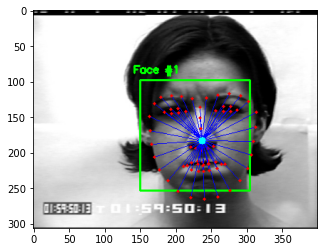

contempt
S138_008_00000009.png


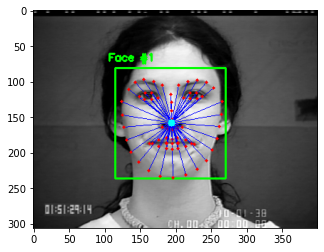

disgust
S005_001_00000011.png


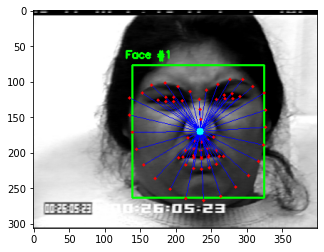

fear
S011_003_00000014.png


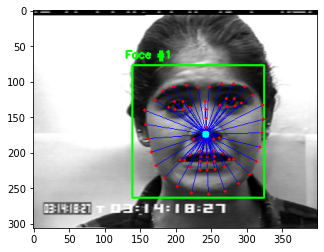

happiness
S010_006_00000015.png


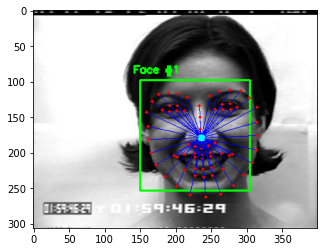

neutral
S005_001_00000001.png


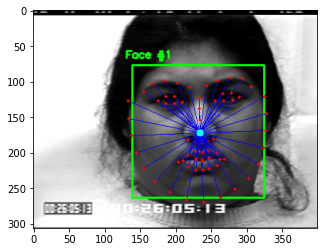

sadness
S011_002_00000022.png


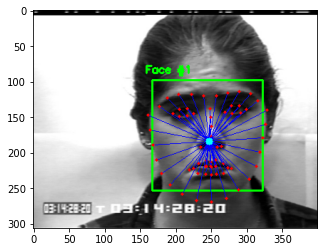

surprise
S010_002_00000014.png


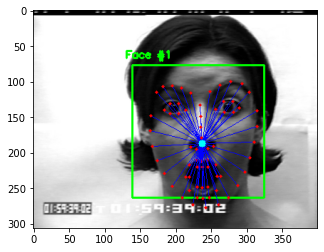

In [7]:
## Populate df with (reshaped) vector data

features = {}
for mood in moods:
    features[mood] = []
    print(mood)
    show = True # show only the first image of each emotion
    for filename in os.listdir(data_path + mood):
        path = data_path + mood + '/' + filename
        vectors = [] # list of vectors
        coords = [] # list of coordinates of facial landmarks (offset by cog)
        
        # load the input image, resize it, and convert it to grayscale
        image = cv2.imread(path)
        image = imutils.resize(image, width=400)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
        rects = detector(gray, 1)

        # loop over the face detections (multiple faces)
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x,y)-coordinates to a NumPy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape) 

            if show:
                # convert dlib's rectangle to a OpenCV-style bounding box
                # [i.e., (x, y, w, h)], then draw the face bounding box
                (x,y,w,h) = face_utils.rect_to_bb(rect)
                cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)

                # show the face number
                cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            
            # get center of gravity (COG)
            cog = tuple(shape.mean(axis=0).astype(int))

            # loop over the (x,y)-coordinates for the facial landmarks
            # and draw them on the image
            for (x,y) in shape:
                if show:
                    cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
                    cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
                
                # get vector magnitude and direction
                vectors.append([mag(cog, (x,y)), angle(cog, (x,y))])
                
                # append coordinates relative to cog
                coords.append([x-cog[0], y-cog[1]])
                
            if show:
                cv2.circle(image, cog, 5, (0,255,255), -1)

        # show the output image with the face detections + facial landmarks
        if show:
            print(filename)
            plt.imshow(image) # adapted for jupyter
            plt.show()
        
        vectors = np.array(vectors)
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor  # normalize magnitudes
        vectors = vectors[:,0] * vectors[:,1]
#         vectors = vectors.reshape(-1)
        df.loc[filename, 'vectors'] = vectors
    
        coords = np.array(coords) * scale_factor
        coords = coords.reshape(-1)
        df.loc[filename, 'coords'] = coords
        
        show = False

In [8]:
df.sample(5)

,mood,vectors,coords
filename,,,
S022_006_00000001.png,neutral,"[-2.5617563704650377, -2.4805273077686967, 2.3...","[-0.8562913085503298, -0.42134969150889245, -0..."
S069_004_00000001.png,neutral,"[-2.6652355109521793, -2.6747409696146227, 2.6...","[-0.8967442656864346, -0.33773485331047537, -0..."
S133_003_00000001.png,neutral,"[-2.70106231297328, -2.6235349220100304, -0.0,...","[-0.9045256429962997, -0.4264192316982556, -0...."
S096_003_00000012.png,disgust,"[-2.68644900259135, -2.6410207989994685, 2.455...","[-0.9039295863773388, -0.3092390690238264, -0...."
S149_002_00000001.png,neutral,"[-2.5916194840173676, -2.5528523441049886, 2.5...","[-0.8655946618150547, -0.43279733090752737, -0..."


# Model training

## CNN

In [18]:
from keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
# One hot encoding for emotion
cnn_data = pd.get_dummies(df.mood).join(df.loc[:,['vectors','coords']])
emotion_classes = cnn_data.columns[:len(moods)]
print('One hot encoded:')
display(cnn_data.sample(5))

# split into train, val and test
x = np.c_[np.array([k for k in cnn_data['vectors'].values]), np.array([k for k in cnn_data['coords'].values])]
y = cnn_data.iloc[:,:8].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

print('Train X shape: ', x_train.shape)
print('Train Y shape: ', y_train.shape)

One hot encoded:


,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,vectors,coords
filename,,,,,,,,,,
S112_005_00000001.png,0,0,0,0,0,1,0,0,"[-2.3613336219918915, -2.3282009813341076, 2.3...","[-0.7892299879024633, -0.38905703628994676, -0..."
S126_002_00000001.png,0,0,0,0,0,1,0,0,"[-2.380915398885842, -2.299639886824631, -2.29...","[-0.7848835855696409, -0.4709301513417845, -0...."
S072_005_00000001.png,0,0,0,0,0,1,0,0,"[-2.738311171870957, -2.653187510315111, 2.673...","[-0.9197781680807426, -0.3924386850477835, -0...."
S069_004_00000001.png,0,0,0,0,0,1,0,0,"[-2.6652355109521793, -2.6747409696146227, 2.6...","[-0.8967442656864346, -0.33773485331047537, -0..."
S029_001_00000019.png,1,0,0,0,0,0,0,0,"[-2.4670721839325043, -2.3722749764291886, 2.3...","[-0.8225354433303612, -0.42497664572068666, -0..."


Train X shape:  (588, 204, 1)
Train Y shape:  (588, 8)


In [21]:
# visualize evaluation
def summarize_diagnostics(history):
    # plot loss
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='validation')
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    # plot accuracy
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='validation')
    plt.ylim(0,1)
    plt.legend()
    plt.show()

In [15]:
num_classes = len(moods)
input_shape = (x_train.shape[1],1)

def buildmodel(model_name, model_num):
    if os.path.exists(model_name):
        model = load_model(model_name)  
        print('Model already built. Loading model.')
    else:
        print('Building model...')
        model = Sequential()
        
        # CS3237 model
        if model_num == 1:
            model.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Conv1D(64, kernel_size=5, activation='relu'))
            model.add(Conv1D(128, kernel_size=5, activation='relu'))
            model.add(Conv1D(64, kernel_size=5, activation='relu'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Flatten())
            model.add(Dense(1024, activation='relu'))
            model.add(Dropout(0.1))
        
        # Ansamma's model
        if model_num == 2:
            model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(68,1), padding='same'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Conv1D(128, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Conv1D(512, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Conv1D(512, kernel_size=3, activation='relu'))
            model.add(MaxPooling1D(pool_size=2, strides=2))
            model.add(Flatten())
            model.add(Dense(256, activation='relu'))
            model.add(Dense(512, activation='relu'))
            model.add(Dropout(0.1))

        # Akmadan's model
#         #1st CNN layer
#         model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout(0.25))

#         #2nd CNN layer
#         model.add(Conv2D(128,(5,5),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #3rd CNN layer
#         model.add(Conv2D(512,(3,3),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #4th CNN layer
#         model.add(Conv2D(512,(3,3), padding='same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Flatten())

#         #Fully connected 1st layer
#         model.add(Dense(256))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))

#         # Fully connected layer 2nd layer
#         model.add(Dense(512))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))

        model.add(Dense(num_classes, activation='softmax'))
        
        print('Model built.')
    
    return model

In [16]:
import logging
logging.disable(logging.INFO)

def train(model, train_data, val_data, test_data, epochs, model_name):
    
    x_train, y_train = train_data[0], train_data[1]
    x_val, y_val = val_data[0], val_data[1]
    x_test, y_test = test_data[0], test_data[1]

    opt = Adam(learning_rate = 0.0001)
#     opt = SGD(learning_rate=0.01, momentum=0.7)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    savemodel = ModelCheckpoint(model_name)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)

    print("Starting training.")
    
    history = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_val, y_val), shuffle=True,
              epochs=epochs, verbose=False,
              callbacks=[savemodel, stopmodel])
    
    summarize_diagnostics(history)

    print('Final training accuracy: %.4f, loss: %.4f' % 
          (history.history['accuracy'][-1], history.history['loss'][-1]))
    print('Final validation accuracy: %.4f, loss: %.4f' % 
          (history.history['val_accuracy'][-1], history.history['val_loss'][-1]))
    
#     print("Done. Now evaluating.")
    print("Done (%d epochs). Now evaluating." % len(history.history['loss']))
    loss, acc = model.evaluate(x=x_test, y=y_test, verbose=False)
    print("Test accuracy: %4.3f, loss: %4.3f"%(acc, loss))

Building model...
Model built.
Starting training.


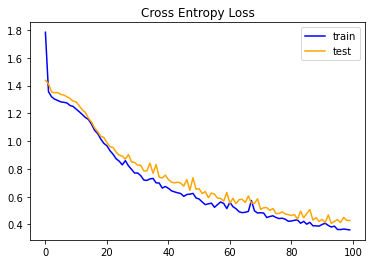

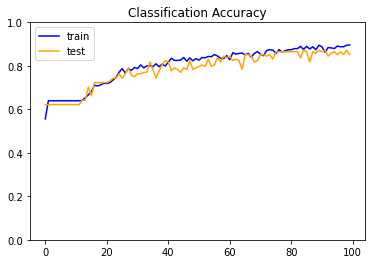

Final training accuracy: 0.8963, loss: 0.3608
Final validation accuracy: 0.8514, loss: 0.4284
Done (100 epochs). Now evaluating.
Test accuracy: 0.842, loss: 0.584


In [19]:
# CS3237 model
MODEL_NAME = model_path + 'emotion-cnn3.hd5'
model = buildmodel(MODEL_NAME, 1)
train(model, (x_train,y_train), (x_val,y_val), (x_test,y_test), 100, MODEL_NAME)

Building model...
Model built.
Starting training.


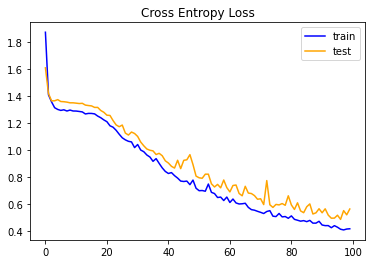

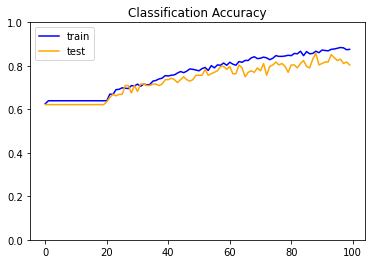

Final training accuracy: 0.8759, loss: 0.4181
Final validation accuracy: 0.8041, loss: 0.5646
Done (100 epochs). Now evaluating.
Test accuracy: 0.842, loss: 0.558


In [219]:
# Ansamma's model
MODEL_NAME = model_path + 'emotion-cnn2.hd5'
model = buildmodel(MODEL_NAME, 2)
train(model, (x_train,y_train), (x_val,y_val), (x_test,y_test), 100, MODEL_NAME

## SVM

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score

In [26]:
# Label encoding for SVM
svm_data = df.copy()
le = LabelEncoder()
svm_data['mood'] = le.fit_transform(svm_data['mood'].values)
svm_classes = list(le.inverse_transform(np.arange(0,8)))
print('Label encoded:')
display(svm_data.sample(5))

# split into train, val and test
x = np.c_[np.array([k for k in svm_data['vectors'].values]), np.array([k for k in svm_data['coords'].values])]
y = svm_data['mood'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

print('Train X shape: ', x_train.shape)
print('Train Y shape: ', y_train.shape)

Label encoded:


,mood,vectors,coords
filename,,,
S113_003_00000015.png,6,"[-2.5812492045847906, -2.5244430110010274, 2.5...","[-0.864677446803922, -0.4042647803239116, -0.8..."
S129_004_00000001.png,5,"[-2.4479358423496214, -2.3880135975328476, -2....","[-0.8141723100806533, -0.43746571884930624, -0..."
S130_002_00000001.png,5,"[-2.3566181638729695, -2.2818462483290145, -2....","[-0.779017104463638, -0.45345771752361025, -0...."
S037_004_00000001.png,5,"[-2.6127012023582528, -2.565312655472276, 2.52...","[-0.8784831152722916, -0.35422706260979503, -0..."
S106_002_00000016.png,6,"[-2.5020884590103756, -2.427738261006724, -0.0...","[-0.8356915152340023, -0.41784575761700116, -0..."


Train X shape:  (736, 204)
Train Y shape:  (736,)


In [27]:
# Training
params = {'C':[10e-3, 10e-2, 0.1, 1, 10], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'decision_function_shape':('ovr', 'ovo')}
svm_pipe = Pipeline([('scaler', StandardScaler()), 
                   ('svm', GridSearchCV(svm.SVC(max_iter=100000, probability=True), params)), ])
svm_pipe.fit(x_train, y_train)
svm_pipe['svm'].best_params_

{'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}

In [28]:
# Prediction
y_train_pred = svm_pipe.predict(x_train)
y_test_pred = svm_pipe.predict(x_test)

# Evaluation
print('Train accuracy: %.4f' % accuracy_score(y_train, y_train_pred))
print('Test accuracy: %.4f' % accuracy_score(y_test, y_test_pred))

Train accuracy: 0.9796
Test accuracy: 0.8804


In [29]:
# Save model
MODEL_NAME = 'emotion-svm2'
pickle.dump(svm_pipe, open(model_path+MODEL_NAME, 'wb'))

## Testing Models

dataset/anger/S045_005_00000030.png


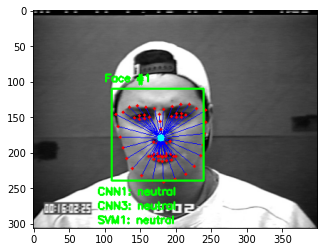

dataset/surprise/S069_002_00000014.png


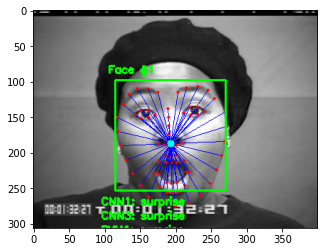

dataset/neutral/S125_002_00000001.png


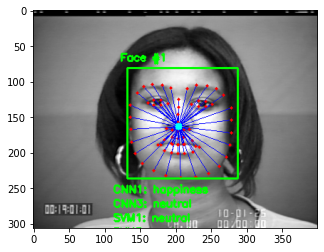

dataset/happiness/S066_003_00000012.png


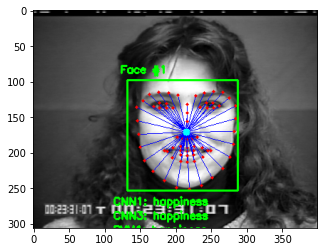

dataset/disgust/S109_005_00000014.png


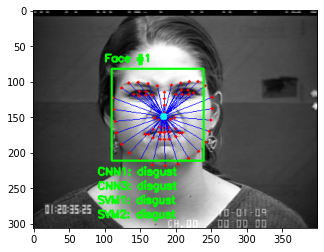

dataset/disgust/S077_006_00000014.png


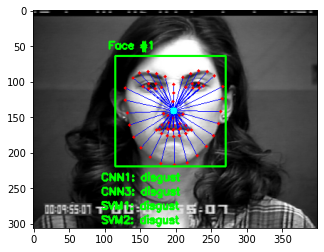

dataset/neutral/S066_004_00000001.png


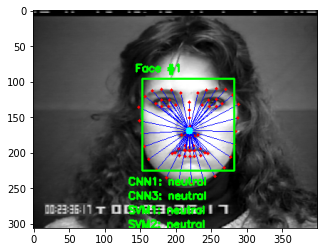

dataset/surprise/S114_001_00000018.png


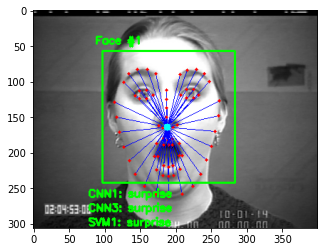

dataset/happiness/S056_004_00000020.png


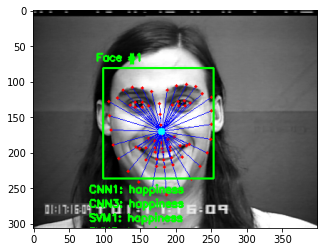

dataset/neutral/S054_003_00000001.png


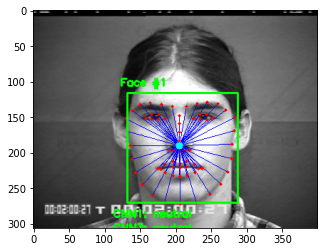

In [35]:
import random

image_filenames = []
for root, dirs, files in os.walk(data_path):
    dir = os.path.basename(root)
    for file in files:
        image_filenames += [data_path + dir + '/' + file]
        
rand_images = random.sample(image_filenames, 10)
rand_images

cnn1 = load_model(model_path+'emotion-cnn1.hd5')
cnn3 = load_model(model_path+'emotion-cnn3.hd5')
svm1 = pickle.load(open(model_path+'emotion-svm', 'rb'))
svm2 = pickle.load(open(model_path+'emotion-svm2', 'rb'))
for path in rand_images:
    vectors, coords = [], []
    classes = {}
    
    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape) 

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)

        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction
            coords.append([x-cog[0], y-cog[1]])

        cv2.circle(image, cog, 5, (0,255,255), -1)
        
        (x,y,w,h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        
        # prediction
        vectors = np.array(vectors)
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
        vectors = vectors[:,0] * vectors[:,1]
        coords = (np.array(coords) * scale_factor).reshape(-1) # 1D array
        
        svm1_input = vectors.reshape(1,-1)
        cnn1_input = vectors.reshape(1, len(vectors), 1)
        svm2_input = np.r_[vectors, coords].reshape(1,-1)
        cnn3_input = np.r_[vectors, coords].reshape(1, len(vectors)+len(coords), 1)
#         print(svm_input.shape, cnn_input.shape)
        
        classes['CNN1'] = emotion_classes[np.argmax(cnn1.predict(cnn1_input))]
        classes['CNN3'] = emotion_classes[np.argmax(cnn3.predict(cnn3_input))]
        classes['SVM1'] = emotion_classes[svm1.predict(svm1_input)[0]]
        classes['SVM2'] = emotion_classes[svm2.predict(svm2_input)[0]]
        i = 1
        for k,v in classes.items():
            cv2.putText(image, '%s: %s' % (k,v), (x-20,y+h+20*i),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            i += 1

    print(path)
    plt.imshow(image) # adapted for jupyter
    plt.show()
#     break